# Import statements

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                             confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay)
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

# Constants

In [13]:
#CONST PROC DO NOT EDIT
thresholds = {
    # Nutrition value               # (operation, threshold value, points, penalty)
    "Fat_Density":                  ("<", 0.02, 2, 7),

    "Saturated_Fats_Density":       ("<", 0.01, 4, 2),

    "Monounsaturated_Fats_Density": (">", 0.01, 1, 1),
    "Polyunsaturated_Fats_Density": (">", 0.01, 1, 1),

    "Carbohydrates_Density":        ("<", 0.10, 2, 4),

    "Sugars_Density":               ("<", 0.05, 4, 4),

    "Protein_Density":              (">", 0.06, 3, 2),

    "Dietary_Fiber_Density":        (">", 0.015, 3, 2),

    "Cholesterol_Density":          ("<", 0.25, 2, 3),

    "Sodium_Density":               ("<", 0.002, 3, 3),

    "Total_Vitamin_Density":        (">", 0.30, 4, 6),
}


FEATURE_NAMES = [
    "Fat_Density",
    "Saturated_Fats_Density",
    "Monounsaturated_Fats_Density",
    "Polyunsaturated_Fats_Density",
    "Carbohydrates_Density",
    "Sugars_Density",
    "Protein_Density",
    "Dietary_Fiber_Density",
    "Cholesterol_Density",
    "Sodium_Density",
    "Total_Vitamin_Density",
]


vitaminColumns = [
            "Vitamin A", "Vitamin B1", "Vitamin B11", "Vitamin B12",
            "Vitamin B2", "Vitamin B3", "Vitamin B5", "Vitamin B6",
            "Vitamin C", "Vitamin D", "Vitamin E", "Vitamin K"
            ]

densities = {
            "Fat": "Fat_Density",
            "Saturated Fats": "Saturated_Fats_Density",
            "Monounsaturated Fats": "Monounsaturated_Fats_Density",
            "Polyunsaturated Fats": "Polyunsaturated_Fats_Density",
            "Carbohydrates": "Carbohydrates_Density",
            "Sugars": "Sugars_Density",
            "Protein": "Protein_Density",
            "Dietary Fiber": "Dietary_Fiber_Density",
            "Cholesterol": "Cholesterol_Density",
            "Sodium": "Sodium_Density",
            }


# Standardizer Class

The Standardizer Class is used to convert the datasets to use densities instead of the raw values.

In [14]:


class Standardizer:
    def __init__(self):
       pass

    def standardize(self, df):
        df = df.copy()

        df = df.fillna(0)
        df["Caloric Value"] = df["Caloric Value"].replace(0, 1)

        cal = df["Caloric Value"]

        for item, item_density in densities.items():
            df[item_density] = df[item] / cal

        df["Total_Vitamin_Density"] = df[vitaminColumns].sum(axis=1) / cal

        df = df.fillna(0)

        return df


# Labeler Class

The Labeler class is used to label each observation in the dataset as healthy or unhealthy. These labels will be used as the truth values for training.

In [15]:
#Labels data based off given instructions *criteria
class Labeler:
    def __init__(self, thresholds : dict):
        self.criteria = thresholds


    #Take in a dataframe and label it accordingly with unhealthy/healthy according to given criteria.
    def label(self, frame: pd.DataFrame) -> pd.DataFrame:
        labels = []
        scores = []

        for row in frame.itertuples(index=False):
            #pull features using getattr
            fat = getattr(row, "Fat_Density", 0)
            sat_fat = getattr(row, "Saturated_Fats_Density", 0)
            mon_fat = getattr(row, "Monounsaturated_Fats_Density", 0)
            poly_fat = getattr(row, "Polyunsaturated_Fats_Density", 0)
            carbs = getattr(row, "Carbohydrates_Density", 0)
            sugars = getattr(row, "Sugars_Density", 0)
            protein = getattr(row, "Protein_Density", 0)
            fiber = getattr(row, "Dietary_Fiber_Density", 0)
            cholesterol = getattr(row, "Cholesterol_Density", 0)
            sodium = getattr(row, "Sodium_Density", 0)
            total_vitamin = getattr(row, "Total_Vitamin_Density", 0)

            vals = [getattr(row,f'food'), fat,sat_fat, mon_fat,poly_fat,carbs,sugars,protein,fiber,cholesterol,sodium, total_vitamin]

            res, score = self.test(vals)
            if (res):
                labels.append("Healthy")
            else:
                labels.append("Unhealthy")
            scores.append(score)

        frame['Health_Label'] = labels
        frame['Health_Score'] = scores
        return frame

    def test(self, values) ->  {bool,int}  :
        i = 1
        score = 0
        test_order = [
            "Fat_Density",
            "Saturated_Fats_Density",
            "Monounsaturated_Fats_Density",
            "Polyunsaturated_Fats_Density",
            "Carbohydrates_Density",
            "Sugars_Density",
            "Protein_Density",
            "Dietary_Fiber_Density",
            "Cholesterol_Density",
            "Sodium_Density",
            "Total_Vitamin_Density"
        ]

        for test in test_order:
            v = values[i]
            thresh = self.criteria[test]
            op = thresh[0]
            val = thresh[1]

            if op == '<':
                if (v < val):
                    score += thresh[2]
                else:
                    score -= thresh[3]
            elif op == '>':
                if (v > val):
                    score += thresh[2]
                else:
                    score -= thresh[3]

            i+=1

        res = score >= 3
        return res,score


# k-NN Class

The k-NN class represents our k-NN model. Has functions for training, creating predictions, and evaluating the performance.

In [16]:

#WRAPPER CLASS FOR KNN MODEL
class KNN:
    def __init__(self, k):
        """Constructor to initialize the model."""
        self.k = k
        self.model = KNeighborsClassifier(n_neighbors = k)


    def train(self,features, ftargets):
        """
        Trains the model
        :param features: The feature data that the model will be trained on.
        :param target_train: The target data that the model will be trained on.
        :return: The trainined model
        """
        self.model.fit(features,ftargets)


    def predict(self, xtest):
        """
        Creates the predictions based on the trained model.
        :param xtest: The feature data that will be fed into the model to create the predictions.
        :return: The predictions created by the model.
        """
        predictions = self.model.predict(xtest)
        return predictions

    def performance_metrics(self, ytest, predictions):
        """
        Calculates the performance metrics based on the model's predictions.
        :param ytest: The correct values.
        :param predictions: The predictions created by the model.
        :return: accuracy score, f1 score, precision score, and recall score
        """
        return (accuracy_score(ytest, predictions),
                f1_score(ytest, predictions, pos_label="Healthy"),
                precision_score(ytest, predictions, pos_label="Healthy"),
                recall_score(ytest, predictions, pos_label="Healthy"))

    def confusion_matrix(self, ytest, predictions):
        """
        Calculates the confusion matrix based on the model's predictions. Prints a basic
        confusion matrix to the terminal and also creates a pretty display of the confusion
        matrix using matplotlib.
        :param ytest: The correct values.
        :param predictions: The predictions created by the model.
        :return: None
        """
        cm = confusion_matrix(ytest, predictions, labels=["Unhealthy", "Healthy"])
        print(f"Confusion Matrix:\n {cm}")
        cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Unhealthy", "Healthy"])
        cm_disp.plot()
        plt.title("k-NN")
        plt.show()

    def roc_curve(self, xtest, ytest):
        """
        Calculates and plots the ROC curve.
        :param xtest: The feature data that corresponds to the correct target values,
        used to get the predicted probabilities.
        :param ytest: The correct values.
        :return: None
        """
        # Get predicted probabilities for positive class
        y_probabilities = self.model.predict_proba(xtest)
        y_probabilities = y_probabilities[:, 0]

        RocCurveDisplay.from_predictions(ytest, y_probabilities, pos_label="Healthy")
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.title("k-NN")
        plt.show()

    def blank_cpy(self):
        return KNN(self.k)

# Neural Network Class

The NN class represents our neural network model. Has functions for training, creating predictions, and evaluating its performance.

In [17]:
#WRAPPER CLASS FOR NN
class NN:
    def __init__(self):
        """Constructor to initialize the model."""
        self.model = MLPClassifier(hidden_layer_sizes=(10,10,10,10), activation = 'relu', solver='adam', max_iter=2000,random_state=42)

    def train(self,features,target_train):
        """
        Trains the model
        :param features: The feature data that the model will be trained on.
        :param target_train: The target data that the model will be trained on.
        :return: The trainined model
        """
        self.model.fit(features, target_train)
        return self.model


    def predict(self, xtest):
        """
        Creates the predictions based on the trained model.
        :param xtest: The feature data that will be fed into the model to create the predictions.
        :return: The predictions created by the model.
        """
        predictions = self.model.predict(xtest)
        return predictions

    def performance_metrics(self, ytest, predictions):
        """
        Calculates the performance metrics based on the model's predictions.
        :param ytest: The correct values.
        :param predictions: The predictions created by the model.
        :return: accuracy score, f1 score, precision score, and recall score
        """
        return (accuracy_score(ytest, predictions),
                f1_score(ytest, predictions, pos_label="Healthy"),
                precision_score(ytest, predictions, pos_label="Healthy"),
                recall_score(ytest, predictions, pos_label="Healthy"))

    def confusion_matrix(self, ytest, predictions):
        """
        Calculates the confusion matrix based on the model's predictions. Prints a basic
        confusion matrix to the terminal and also creates a pretty display of the confusion
        matrix using matplotlib.
        :param ytest: The correct values.
        :param predictions: The predictions created by the model.
        :return: None
        """
        cm = confusion_matrix(ytest, predictions, labels=["Unhealthy", "Healthy"])
        print(f"Confusion Matrix:\n {cm}")
        cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Unhealthy", "Healthy"])
        cm_disp.plot()
        plt.title("Neural Network")
        plt.show()

    def roc_curve(self, xtest, ytest):
        """
        Calculates and plots the ROC curve.
        :param xtest: The feature data that corresponds to the correct target values,
        used to get the predicted probabilities.
        :param ytest: The correct values.
        :return: None
        """
        # Get predicted probabilities for positive class
        y_probabilities = self.model.predict_proba(xtest)
        y_probabilities = y_probabilities[:, 0]

        RocCurveDisplay.from_predictions(ytest, y_probabilities, pos_label="Healthy")
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.title("Neural Network")
        plt.show()

    def blank_cpy(self):
        return NN()


# Random Forest Class

The RF class represents our random forest model. Has functions for training, predicting, and evaluating.

In [18]:

class RF:
    def __init__(self):
        """Constructor to initialize the model."""
        self.model = RandomForestClassifier(n_estimators=60, max_depth=None, random_state=42) #Maybe we need tro switch the n estimators here.

    def train(self, xtrain, ytrain):
        """
        Trains the model
        :param features: The feature data that the model will be trained on.
        :param target_train: The target data that the model will be trained on.
        :return: The trainined model
        """
        self.model.fit(xtrain, ytrain)

    def predict(self, xtest):
        """
        Creates the predictions based on the trained model.
        :param xtest: The feature data that will be fed into the model to create the predictions.
        :return: The predictions created by the model.
        """
        predictions = self.model.predict(xtest)
        return predictions

    def performance_metrics(self, ytest, predictions):
        """
        Calculates the performance metrics based on the model's predictions.
        :param ytest: The correct values.
        :param predictions: The predictions created by the model.
        :return: accuracy score, f1 score, precision score, and recall score
        """
        return (accuracy_score(ytest, predictions),
                f1_score(ytest, predictions, pos_label="Healthy"),
                precision_score(ytest, predictions, pos_label="Healthy"),
                recall_score(ytest, predictions, pos_label="Healthy"))

    def confusion_matrix(self, ytest, predictions):
        """
        Calculates the confusion matrix based on the model's predictions. Prints a basic
        confusion matrix to the terminal and also creates a pretty display of the confusion
        matrix using matplotlib.
        :param ytest: The correct values.
        :param predictions: The predictions created by the model.
        :return: None
        """
        cm = confusion_matrix(ytest, predictions, labels=["Unhealthy", "Healthy"])
        print(f"Confusion Matrix:\n {cm}")
        cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Unhealthy", "Healthy"])
        cm_disp.plot()
        plt.title("Random Forest")
        plt.show()

    def roc_curve(self, xtest, ytest):
        """
        Calculates and plots the ROC curve.
        :param xtest: The feature data that corresponds to the correct target values,
        used to get the predicted probabilities.
        :param ytest: The correct values.
        :return: None
        """
        # Get predicted probabilities for positive class
        y_probabilities = self.model.predict_proba(xtest)
        y_probabilities = y_probabilities[:, 0]

        # Create ROC curve
        RocCurveDisplay.from_predictions(ytest, y_probabilities, pos_label="Healthy")
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.title("Random Forest")
        plt.show()

    def blank_cpy(self):
        return RF()

# k-Fold Cross Validation

These functions run the k-fold cross validation and displays the results to the terminal. Used on all 3 models.

In [19]:

def KFoldCV(name_of_model, m, features, target, k):
    """K-Fold Cross Validation for each model. """

    print(f"====Starting Cross Validation for {name_of_model}====")
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = []
    for train, test in kfold.split(features):
        metrics = []
        xtrain, xtest = features.iloc[train], features.iloc[test]
        ytrain, ytest = target.iloc[train], target.iloc[test]
        model = m.blank_cpy()
        model.train(xtrain, ytrain)
        yhat = model.predict(xtest)
        accuracy_NN, f1_NN, precision_NN, recall_NN = model.performance_metrics(ytest, yhat)
        metrics.append(f"{accuracy_NN:.8f}")
        metrics.append(f"{f1_NN:.8f}")
        metrics.append(f"{precision_NN:.8f}")
        metrics.append(f"{recall_NN:.8f}")
        scores.append(metrics)



    KFoldRes(name_of_model, scores)

def KFoldRes(name_of_model, KFScores):
    i = 1
    print("Fold #:           Accuracy       F1            Precision       Recall")
    for score in KFScores:
        print(f"Fold{i}: Metrics = {score}")
        i+=1
    print("========================================\n")

# Bootstrapping

These functions run the bootstrapping method and displays the results to the terminal. Used on all 3 models.

In [20]:
def bootstrapEval(name_of_model, m, features, target, iterations):
    """Bootstrapping procedure for each model."""

    print(f"Starting Bootstrap Evaluations for {name_of_model}")
    BSscores = []

    for iteration in range(iterations):
        #grab bootstrap samples
        BSFeatures, BSTargets = resample(features, target, replace = True)

        OOB = ~features.index.isin(BSFeatures.index)
        OOBFeatures = features[OOB]
        OOBTargets = target[OOB]

        if len(OOB) == 0:
            continue
        model = m.blank_cpy()
        model.train(BSFeatures, BSTargets)

        yhat = model.predict(OOBFeatures)

        BSscores.append(accuracy_score(OOBTargets, yhat))

    bootstrapRes(name_of_model, BSscores)

def bootstrapRes(name_of_model, BSscores):
    scores = np.array(BSscores)

    mean = scores.mean()
    std = scores.std()
    ci_lower = np.percentile(scores, 2.5)
    ci_upper = np.percentile(scores, 97.5)
    median = np.median(scores)
    iqr = np.percentile(scores, 75) - np.percentile(scores, 25)

    print(f"\n====Bootstrap Evaluation {name_of_model}====")
    print(f"Mean Accuracy:        {mean:.8f}")
    print(f"Std Deviation:        {std:.8f}")
    print(f"95% CI:               [{ci_lower:.8f}, {ci_upper:.8f}]")
    print(f"Median:               {median:.8f}")
    print(f"IQR:                  {iqr:.8f}")
    print("========================================\n")


# Main Function

Our driver code that brings everything together to create, train, and evaluate the 3 models that we tested.

In [21]:
def main():
    """Driver code to create, train, and evaluate the 3 models."""

    # Reads in the datasets from all 5 files
    # Assumes the directory of current directory -> Files -> FOOD-DATA-GROUP{1,2,3,4,5}.csv
    df1 = pd.read_csv("Files/FOOD-DATA-GROUP1.csv")
    df2 = pd.read_csv("Files/FOOD-DATA-GROUP2.csv")
    df3 = pd.read_csv("Files/FOOD-DATA-GROUP3.csv")
    df4 = pd.read_csv("Files/FOOD-DATA-GROUP4.csv")
    df5 = pd.read_csv("Files/FOOD-DATA-GROUP5.csv")

    # Combines the 5 DataFrames into a single DataFrame
    df = pd.concat([df1,df2,df3,df4,df5], ignore_index=True)

    # Uses standardizer to convert all nutritional values to densities
    std = Standardizer()
    df = std.standardize(df)

    # Uses Labeler to label each food as healthy or unhealthy
    # These labels will be used as the ground truth values for our models to compare to
    L = Labeler(thresholds)
    df = L.label(df)

    # Pull out features and target
    features = df[FEATURE_NAMES]
    target = df["Health_Label"]

    # Split data into training set and testing set
    xtrain, xtest, ytrain, ytest = train_test_split(
        features, target,
        train_size=0.7,
        test_size=0.3,
        stratify=target, #get binary classification split
        random_state=42
    )

    # Scales the features using StandardScaler
    # Encoding not required because of model design
    scaler = StandardScaler()
    xtrain = scaler.fit_transform(xtrain)
    xtest = scaler.transform(xtest)

    # Creating the models we're testing
    Model1 = NN() # Neural network
    Model2 = KNN(k=7) # k-NN
    Model3 = RF() # Random forest

    # Training the models
    Model1.train(xtrain, ytrain)
    Model2.train(xtrain, ytrain)
    Model3.train(xtrain, ytrain)

    print("Training models:")

    # Evaluating each model's performance
    # Neural network metrics
    predictionsNN = Model1.predict(xtest)
    accuracy_NN, f1_NN, precision_NN, recall_NN = Model1.performance_metrics(ytest, predictionsNN)
    print("\n=== Neural Network===")
    print(f"Accuracy: {accuracy_NN}")
    print(f"F1 score: {f1_NN}")
    print(f"Precision: {precision_NN}")
    print(f"Recall: {recall_NN}")
    Model1.confusion_matrix(ytest, predictionsNN)
    Model1.roc_curve(xtest, ytest)

    # k-NN metrics
    predictionsKNN = Model2.predict(xtest)
    accuracy_KNN, f1_KNN, precision_KNN, recall_KNN = Model2.performance_metrics(ytest, predictionsKNN)
    print("\n=== k-NN ===")
    print(f"Accuracy: {accuracy_KNN}")
    print(f"F1 score: {f1_KNN}")
    print(f"Precision: {precision_KNN}")
    print(f"Recall: {recall_KNN}")
    Model2.confusion_matrix(ytest, predictionsKNN)
    Model2.roc_curve(xtest, ytest)

    # Random forest metrics
    predictionsRF = Model3.predict(xtest)
    accuracy_RF, f1_RF, precision_RF, recall_RF = Model3.performance_metrics(ytest, predictionsRF)
    print("\n=== Random Forest===")
    print(f"Accuracy: {accuracy_RF}")
    print(f"F1 score: {f1_RF}")
    print(f"Precision: {precision_RF}")
    print(f"Recall: {recall_RF}")
    Model3.confusion_matrix(ytest, predictionsRF)
    Model3.roc_curve(xtest, ytest)


    #Use KFold Method Above.
    print("Cross Validation: ")

    KFoldCV("Neural Network", Model1, features, target, 10)
    KFoldCV("K-Nearest Neighbors", Model2, features, target, 10)
    KFoldCV("Random Forest", Model3, features, target, 10)

    #Bootstrap Eval


    bootstrapEval("Neural Network", Model1, features, target, 50)
    bootstrapEval("K-Nearest Neighbors", Model2, features, target, 50)
    bootstrapEval("Random Forest", Model3, features, target, 50)







# Output

Training models:

=== Neural Network===
Accuracy: 0.9090909090909091
F1 score: 0.8012618296529969
Precision: 0.7696969696969697
Recall: 0.8355263157894737
Confusion Matrix:
 [[503  38]
 [ 25 127]]


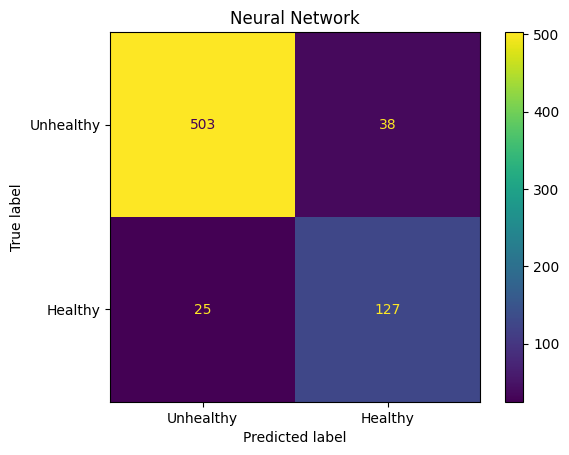

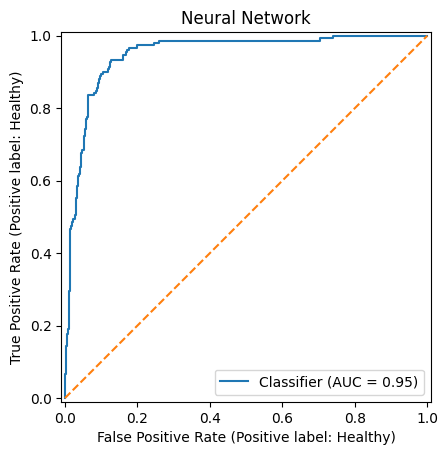


=== k-NN ===
Accuracy: 0.8903318903318903
F1 score: 0.7579617834394905
Precision: 0.7345679012345679
Recall: 0.7828947368421053
Confusion Matrix:
 [[498  43]
 [ 33 119]]


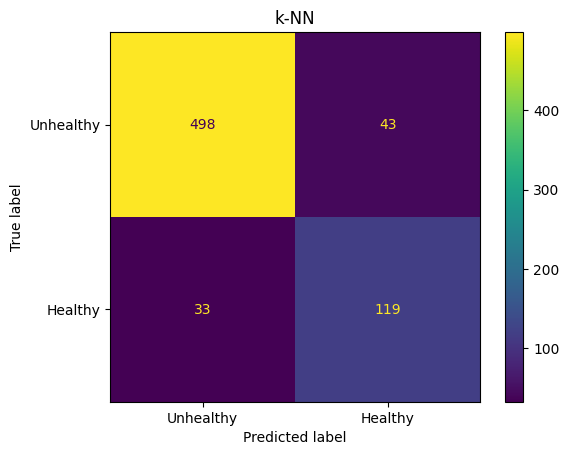

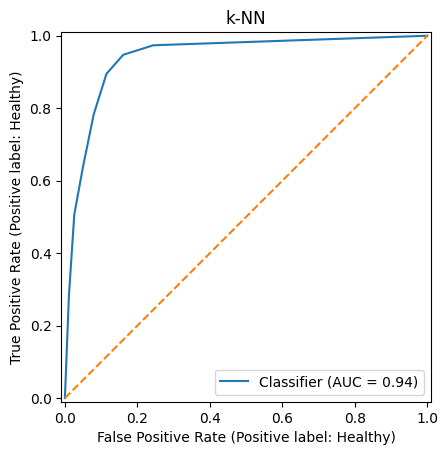


=== Random Forest===
Accuracy: 0.9595959595959596
F1 score: 0.9066666666666666
Precision: 0.918918918918919
Recall: 0.8947368421052632
Confusion Matrix:
 [[529  12]
 [ 16 136]]


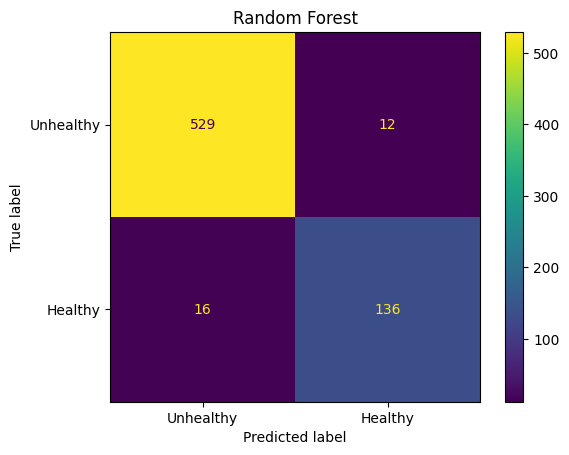

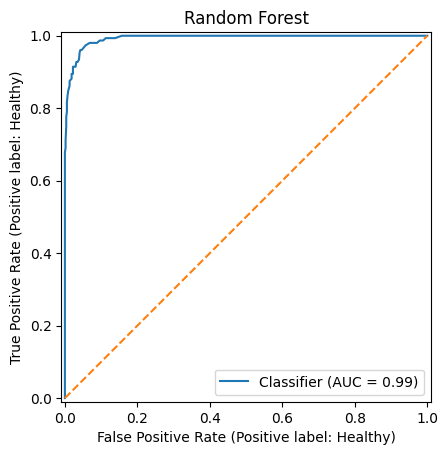

Cross Validation: 
====Starting Cross Validation for Neural Network====
Fold #:           Accuracy       F1            Precision       Recall
Fold1: Metrics = ['0.86580087', '0.72566372', '0.69491525', '0.75925926']
Fold2: Metrics = ['0.91341991', '0.79166667', '0.76000000', '0.82608696']
Fold3: Metrics = ['0.90476190', '0.78431373', '0.81632653', '0.75471698']
Fold4: Metrics = ['0.89610390', '0.76000000', '0.82608696', '0.70370370']
Fold5: Metrics = ['0.87445887', '0.74336283', '0.75000000', '0.73684211']
Fold6: Metrics = ['0.89177489', '0.73684211', '0.76086957', '0.71428571']
Fold7: Metrics = ['0.93939394', '0.83333333', '0.85365854', '0.81395349']
Fold8: Metrics = ['0.87445887', '0.70103093', '0.75555556', '0.65384615']
Fold9: Metrics = ['0.87878788', '0.69565217', '0.71111111', '0.68085106']
Fold10: Metrics = ['0.89130435', '0.75247525', '0.77551020', '0.73076923']

====Starting Cross Validation for K-Nearest Neighbors====
Fold #:           Accuracy       F1            Precision  

In [22]:
main()